/var/folders/yh/hv33dfk17snff4td_nxq68wh0000gp/T/ipykernel_54291/393768437.py:14: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  lc_pdcsap = lc.PDCSAP_FLUX


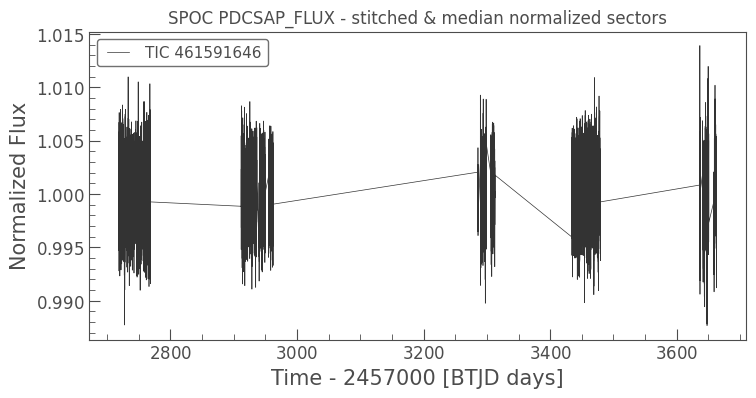

In [ ]:
import lightkurve as lk
import matplotlib.pyplot as plt
import pandas as pd

# Search for all TESS SPOC light curves for your target
search_result = lk.search_lightcurve("TOI 2155", mission="TESS", author="SPOC")

# Download all sectors (returns a LightCurveCollection)
lc_collection = search_result.download_all()

cleaned_lcs = []  
for lc in lc_collection:
    # Use PDCSAP_FLUX, remove NaNs in time and flux
    lc_pdcsap = lc.PDCSAP_FLUX
    if lc_pdcsap is not None:
        lc_clean = lc_pdcsap.remove_nans()
        # Normalize by median flux
        #lc_norm = lc_clean.normalize()
        cleaned_lcs.append(lc_clean)

# Create a new LightCurveCollection from cleaned light curves
lc_clean_collection = lk.LightCurveCollection(cleaned_lcs)

# Stitch all sectors together and normalize by median flux
lc_stitched = lc_clean_collection.stitch()

# Plot stitched light curve
lc_stitched.plot()
plt.title("SPOC PDCSAP_FLUX - stitched & median normalized sectors")
plt.show()

# Prepare DataFrame to save as CSV
df = pd.DataFrame({
    '#time': lc_stitched.time.value,
    'pdcsap_flux': lc_stitched.flux.value,
    'pdcsap_flux_err': lc_stitched.flux_err.value if lc_stitched.flux_err is not None else [None]*len(lc_stitched.flux)
})

# Save to CSV
df.to_csv('TOI2155_spoc_stitched_normalized.csv', index=False)


In [2]:
import pandas as pd
import lightkurve as lk
import numpy as np
import matplotlib.pyplot as plt


# Load your light curve
df = pd.read_csv('TOI2155_spoc_stitched_normalized.csv')


time= df['#time']
flux= df['pdcsap_flux']
print(flux)
flux_error= df['pdcsap_flux_err']

plt.plot(time, flux, 'k.', markersize=1)
plt.xlabel('Time (BJD - 2457000)')


0         0.999074
1         0.997890
2         0.998689
3         1.000159
4         0.999195
            ...   
114616    0.999915
114617    1.000291
114618    0.996997
114619    0.998535
114620    0.998712
Name: pdcsap_flux, Length: 114621, dtype: float64


Text(0.5, 0, 'Time (BJD - 2457000)')

In [3]:
import numpy as np
from wotan import flatten
flatten_lc, trend_lc = flatten(
    time,                 # Array of time values
    flux,                 # Array of flux values
    method='biweight',
    window_length=0.6,    # The length of the filter window in units of ``time``
    edge_cutoff=0.5,      # length (in units of time) to be cut off each edge.
    break_tolerance=0.5,  # Split into segments at breaks longer than that
    return_trend=True,    # Return trend and flattened light curve
    cval=5.0              # Tuning parameter for the robust estimators
    )

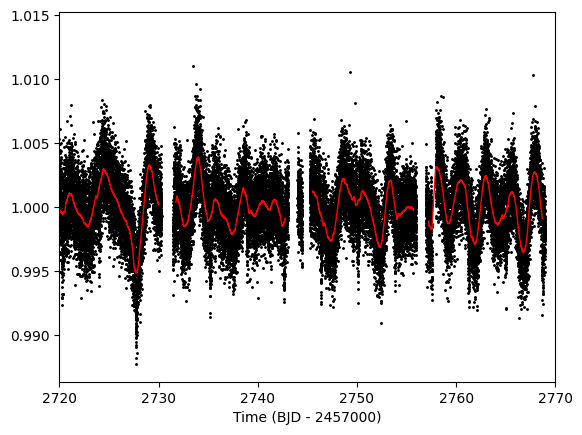

In [4]:
import matplotlib.pyplot as plt
from matplotlib import rcParams; rcParams["figure.dpi"] = 150

plt.scatter(time, flux, s=1, color='black')
plt.plot(time, trend_lc, color='red', linewidth=1)
plt.xlim(2720,2770)
plt.show();
plt.close()

plt.figure(figsize=(10, 8))
# plt.scatter(time, flux, color='black', linewidth=1)
plt.scatter(time, flatten_lc, s=0.5, color='cyan');
# plt.xlim(2720,2770)

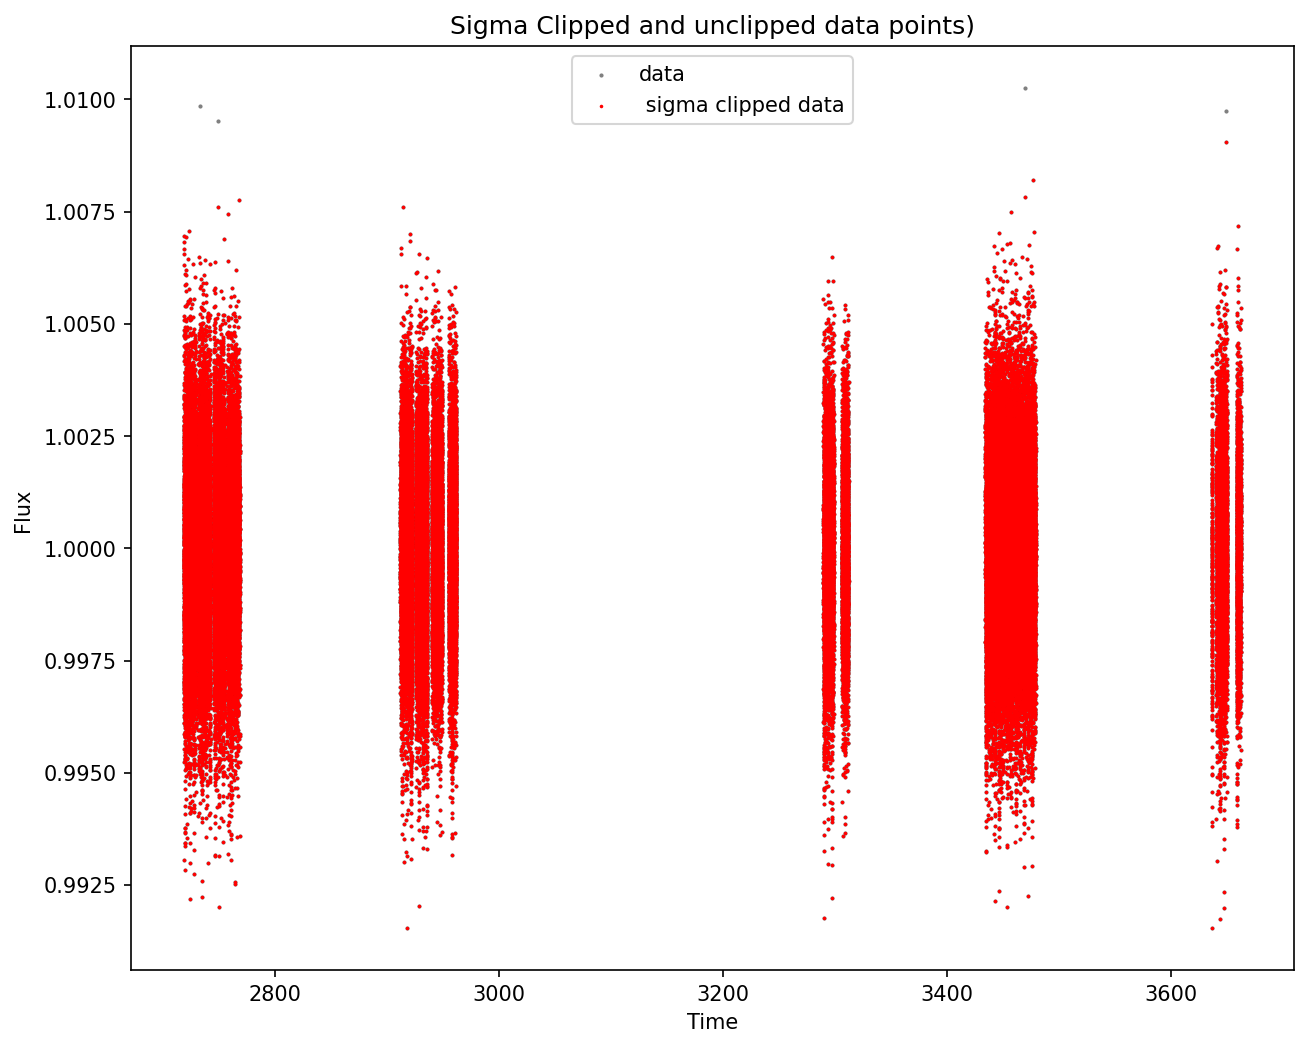

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams; rcParams["figure.dpi"] = 150
from astropy.stats import sigma_clip

# --- Apply 5-sigma clipping ---
clipped_flux = sigma_clip(flatten_lc, sigma=5, maxiters=5)

# --- Only keep unmasked values ---
mask = ~clipped_flux.mask
time_clipped = time[mask]
flux_clipped = flatten_lc[mask]
flux_error_clipped = flux_error[mask] 


# --- Plot ---
plt.figure(figsize=(10, 8))

plt.scatter(time, flatten_lc, s=1, color='gray',label="data");
plt.scatter(time_clipped, flux_clipped, s=0.5, color='red',label=" sigma clipped data")
plt.xlabel("Time")
plt.ylabel("Flux ")
plt.title("Sigma Clipped and unclipped data points)")
plt.legend()
plt.show()


In [8]:
df = pd.DataFrame({
    '#time': time_clipped + 2457000,
    'flux': flux_clipped,
    'flux_err': flux_error_clipped
}).sort_values(by='#time')

# Save to CSV
df.to_csv('TESS_detrended.csv', index=False)
